In [1]:
import sys
sys.path.append('..')
from src.func import iteratee

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data 

In [3]:
df = pd.read_csv("../data/raw/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.drop(columns="Insulin", inplace=True)

# Dataset Splitting 

In [5]:
X = df.drop(columns="Outcome")
y = df['Outcome'].values # .values digunakan karena Series/DataFrame pandas tidak bisa dikonversi ke Tensor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 7), (154, 7), (614,), (154,))

# Preprocess Data 

In [6]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age
353,1,90,62,12,27.2,0.580,24
711,5,126,78,27,29.6,0.439,40
373,2,105,58,40,34.9,0.225,25
46,1,146,56,0,29.7,0.564,29
682,0,95,64,39,44.6,0.366,22


In [7]:
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

preprocessor = ColumnTransformer([
    ('numeric', numerical_pipeline, X_train.columns)
])

In [8]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

# Dataset

In [9]:
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [10]:
train_set = TensorDataset(X_train, y_train)
trainloader = DataLoader(train_set, batch_size=64, shuffle=True)
test_set = TensorDataset(X_test, y_test)
testloader = DataLoader(test_set, batch_size=64)

# Training Preparation

In [11]:
X_train.shape

torch.Size([614, 7])

In [12]:
model = nn.Sequential(
    nn.Linear(7, 16),
    nn.ReLU(),
#     nn.Dropout(0.25),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(4, 2),
    nn.LogSoftmax(1)
).to(device)

criterion = nn.NLLLoss()
#Semisal tidak menggunakan nn.LogSoftMax(), maka criterionnya menggunakan nn.CrossEntropyLoss
optimizer = optim.AdamW(model.parameters(), lr=0.003)

# Training Loop 

In [13]:
epochs = 1000

train_cost, test_cost = [], []
train_accuracy, test_accuracy = [], []

for i in range(epochs):
    cost, accuracy = iteratee("train", train_set, trainloader, model, criterion, optimizer, device)
    train_cost.append(cost)
    train_accuracy.append(accuracy)
    
    with torch.no_grad():
        cost, accuracy = iteratee("test", test_set, testloader, model, criterion, optimizer, device)
        test_cost.append(cost)
        test_accuracy.append(accuracy)

    print(f"\rEpoch: {i+1:4}/{epochs:4} | "
          f"train_cost: {train_cost[-1]:.4f} | test_cost: {train_cost[-1]:.4f} | "
          f"train_accuracy: {train_accuracy[-1]:.4f} | test_accuracy: {test_accuracy[-1]:.4f}", end=" ")

Epoch: 1000/1000 | train_cost: 0.4255 | test_cost: 0.4255 | train_accuracy: 0.7541 | test_accuracy: 0.7532 

# Cost History 

In [14]:
import matplotlib.pyplot as plt

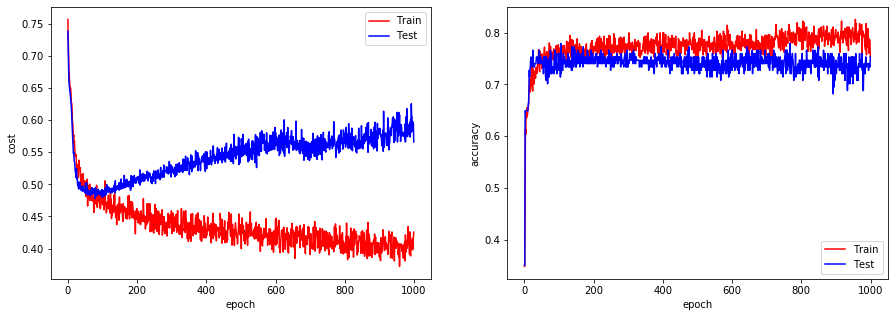

In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(train_cost, 'r-', label="Train")
plt.plot(test_cost, 'b-', label="Test")
plt.xlabel("epoch"); plt.ylabel("cost"); plt.legend();
plt.subplot(122)
plt.plot(train_accuracy, 'r-', label="Train")
plt.plot(test_accuracy, 'b-', label="Test")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend();

# Predict

In [16]:
X_test.shape

torch.Size([154, 7])

In [17]:
with torch.no_grad():
    model.eval()
    output = model(X_test)

In [18]:
torch.exp(output)

tensor([[2.3838e-01, 7.6162e-01],
        [6.1934e-01, 3.8066e-01],
        [6.6827e-01, 3.3173e-01],
        [6.6632e-01, 3.3368e-01],
        [1.0000e+00, 1.5214e-08],
        [5.3627e-01, 4.6373e-01],
        [5.3627e-01, 4.6373e-01],
        [6.5192e-02, 9.3481e-01],
        [9.5465e-01, 4.5346e-02],
        [1.6122e-01, 8.3878e-01],
        [7.2490e-01, 2.7510e-01],
        [2.4297e-02, 9.7570e-01],
        [9.6565e-01, 3.4348e-02],
        [9.1885e-01, 8.1145e-02],
        [6.7117e-01, 3.2883e-01],
        [5.3627e-01, 4.6373e-01],
        [5.9273e-01, 4.0727e-01],
        [9.3167e-01, 6.8325e-02],
        [1.7227e-01, 8.2773e-01],
        [7.4912e-01, 2.5088e-01],
        [5.3627e-01, 4.6373e-01],
        [5.3009e-01, 4.6991e-01],
        [7.4810e-01, 2.5190e-01],
        [5.2804e-02, 9.4720e-01],
        [2.4919e-01, 7.5081e-01],
        [9.5209e-01, 4.7915e-02],
        [2.8258e-01, 7.1742e-01],
        [9.8208e-01, 1.7919e-02],
        [8.7299e-01, 1.2701e-01],
        [9.970

In [19]:
output

tensor([[-1.4339e+00, -2.7230e-01],
        [-4.7910e-01, -9.6586e-01],
        [-4.0306e-01, -1.1034e+00],
        [-4.0598e-01, -1.0976e+00],
        [ 0.0000e+00, -1.8001e+01],
        [-6.2311e-01, -7.6846e-01],
        [-6.2311e-01, -7.6846e-01],
        [-2.7304e+00, -6.7415e-02],
        [-4.6406e-02, -3.0934e+00],
        [-1.8250e+00, -1.7581e-01],
        [-3.2172e-01, -1.2906e+00],
        [-3.7174e+00, -2.4597e-02],
        [-3.4952e-02, -3.3712e+00],
        [-8.4627e-02, -2.5115e+00],
        [-3.9874e-01, -1.1122e+00],
        [-6.2311e-01, -7.6846e-01],
        [-5.2302e-01, -8.9827e-01],
        [-7.0771e-02, -2.6835e+00],
        [-1.7587e+00, -1.8907e-01],
        [-2.8885e-01, -1.3828e+00],
        [-6.2311e-01, -7.6846e-01],
        [-6.3470e-01, -7.5522e-01],
        [-2.9022e-01, -1.3787e+00],
        [-2.9412e+00, -5.4249e-02],
        [-1.3895e+00, -2.8661e-01],
        [-4.9101e-02, -3.0383e+00],
        [-1.2638e+00, -3.3209e-01],
        [-1.8081e-02, -4.021

In [20]:
pred = output.argmax(1)
pred

tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 0])

# Accuracy 

In [21]:
accuracy = (y_test == pred).to(torch.float32).mean().item()
accuracy

0.7532467246055603

# Save Model and Weight 

In [22]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 5.0313e-01,  2.2272e-01,  5.5175e-02,  9.3067e-01,  3.1287e-01,
                        4.2557e-01, -1.9446e-01],
                      [ 1.1000e-01, -3.4392e-01, -2.7654e-01,  8.4637e-02, -7.8029e-01,
                       -2.9332e-01,  8.3227e-01],
                      [-4.2336e-01,  5.8547e-01,  3.1626e-01, -3.8542e-01,  3.2624e-01,
                        4.0953e-02, -2.5256e-01],
                      [-9.2255e-01,  4.2046e-01, -4.1822e-01, -2.2477e-01,  4.2254e-01,
                       -2.1998e-01,  3.5125e-01],
                      [-1.9579e-01, -1.4628e-01, -2.0467e-01,  5.1510e-02,  1.9506e-01,
                        9.4112e-02,  2.6335e-01],
                      [-7.8575e-01, -4.2921e-02,  1.6182e-04, -9.1870e-02, -2.2464e-01,
                        2.6944e-01,  1.2356e-01],
                      [-1.2578e-01, -1.3873e-01, -1.2057e-02, -1.4749e-01, -1.6366e-01,
                        3.5068e-01, -3.6522e-01],
        

In [23]:
torch.save(model.state_dict(), "../models/weights.pth")

In [26]:
log = {
    "train_cost": train_cost,
    "test_cost": test_cost,
    "train_accuracy": train_accuracy,
    "test_accuracy": test_accuracy
}
torch.save(log, "../models/logs.pth")

# Load Model

In [27]:
model = nn.Sequential(
    nn.Linear(7, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(4, 2),
    nn.LogSoftmax(1)
).to(device)

In [30]:
model.state_dict() # ini jelas tidak akan sama, dikarenakan ini adalah weight awal yang 
# muncul secara random setelah menjalankan arsitektur dari awal.

OrderedDict([('0.weight',
              tensor([[-0.1628, -0.3358, -0.2748, -0.0626,  0.1100,  0.1274,  0.1094],
                      [-0.1880, -0.2207,  0.0212, -0.3386,  0.3319, -0.2182,  0.2493],
                      [ 0.2250, -0.0703,  0.1273, -0.0603, -0.0901, -0.2635, -0.1554],
                      [ 0.1547, -0.3754, -0.0728,  0.1970, -0.3058,  0.0764, -0.0380],
                      [ 0.2559,  0.2932,  0.3102,  0.1359,  0.1633, -0.3644, -0.3163],
                      [-0.2163,  0.0248,  0.3301,  0.3216, -0.1486,  0.2469,  0.0419],
                      [ 0.1118,  0.0849,  0.2098, -0.0042,  0.3248,  0.2825,  0.0728],
                      [-0.3609,  0.1576, -0.2845, -0.0727, -0.0014, -0.3600,  0.0256],
                      [-0.1192, -0.3768, -0.2820,  0.1854,  0.0872,  0.2408, -0.2448],
                      [-0.2246, -0.3719,  0.3530,  0.2426, -0.2173, -0.1019,  0.0612],
                      [-0.2148, -0.0706,  0.2109,  0.2550, -0.0181,  0.2109, -0.2145],
                 

In [31]:
weights = torch.load("../models/weights.pth", map_location="cpu")
# load secara default harus cpu.
# Karena tidak menutup kemungkinan bahwa model tester tidak memiliki gpu pada environment
# hardwarenya.

In [32]:
with torch.no_grad():
    model.eval()
    output = model(X_test)
    pred = output.argmax(1)
    accuracy = (y_test == pred).to(torch.float32).mean()
accuracy
# hasil berubah dari hasi awal karena weightnya belum di-overwrite.
# Ini dikarenakan random (yang dimaksud adalah random weight, bukan random prediction)

tensor(0.6494)

In [33]:
model.load_state_dict(weights)
model = model.to(device)

In [34]:
with torch.no_grad():
    model.eval()
    output = model(X_test)
    pred = output.argmax(1)
    accuracy = (y_test == pred).to(torch.float32).mean()
accuracy

tensor(0.7532)

In [35]:
model.state_dict()
# Weights sudah mengikuti state yang didapatkan pada training

OrderedDict([('0.weight',
              tensor([[ 5.0313e-01,  2.2272e-01,  5.5175e-02,  9.3067e-01,  3.1287e-01,
                        4.2557e-01, -1.9446e-01],
                      [ 1.1000e-01, -3.4392e-01, -2.7654e-01,  8.4637e-02, -7.8029e-01,
                       -2.9332e-01,  8.3227e-01],
                      [-4.2336e-01,  5.8547e-01,  3.1626e-01, -3.8542e-01,  3.2624e-01,
                        4.0953e-02, -2.5256e-01],
                      [-9.2255e-01,  4.2046e-01, -4.1822e-01, -2.2477e-01,  4.2254e-01,
                       -2.1998e-01,  3.5125e-01],
                      [-1.9579e-01, -1.4628e-01, -2.0467e-01,  5.1510e-02,  1.9506e-01,
                        9.4112e-02,  2.6335e-01],
                      [-7.8575e-01, -4.2921e-02,  1.6182e-04, -9.1870e-02, -2.2464e-01,
                        2.6944e-01,  1.2356e-01],
                      [-1.2578e-01, -1.3873e-01, -1.2057e-02, -1.4749e-01, -1.6366e-01,
                        3.5068e-01, -3.6522e-01],
        